In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo

In [4]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")
test.head()

,id,ingredients
0,10210,"[barbecue sauce, yellow onion, prepared pizza ..."
1,2310,"[olive oil, stewed tomatoes, hot sauce, chicke..."
2,33213,"[chopped bell pepper, cilantro leaves, white o..."
3,16902,"[tomatoes, purple onion, cumin seed, red lenti..."
4,9056,"[chile powder, lime, blackpepper, ground clove..."


In [23]:
# onehot encoder for ingredients
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
expandedLabelData_train = mlb.fit_transform(train["ingredients"])
labelClasses = mlb.classes_
expandedLabelData_test = mlb.fit_transform(test["ingredients"])
labelClasses_2 = mlb.classes_

expandedLabels_train = pd.DataFrame(expandedLabelData_train, columns=labelClasses)
expandedLabels_test = pd.DataFrame(expandedLabelData_test, columns=labelClasses_2)
print(expandedLabels_train)
print()
print(expandedLabels_test)

       (    oz.) tomato sauce  (   oz.) tomato paste  \
0                           0                      0   
1                           0                      0   
2                           0                      0   
3                           0                      0   
4                           0                      0   
...                       ...                    ...   
29769                       0                      0   
29770                       0                      0   
29771                       0                      0   
29772                       0                      0   
29773                       0                      0   

       (10 oz.) frozen chopped spinach  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   
...                                ...   
29769                            

In [24]:
# shuffle data
from numpy import nan

def shuffle(df_origin): 
    df = df_origin.sample(frac=1,random_state=113)#,random_state=113
    df2= df.reset_index(drop=True)
    return df2

df = pd.DataFrame(train)
df = pd.concat([df,expandedLabels_train], axis = 1)
df_shuffle_train = shuffle(df)
print(df_shuffle_train)

df = pd.DataFrame(test)
df = pd.concat([df,expandedLabels_test], axis = 1)
df_shuffle_test = shuffle(df)
print(df_shuffle_test)
df_shuffle_test.to_csv("shuffle_test.csv")

df_mix = pd.concat([df_shuffle_train, df_shuffle_test])
df_mix= df_mix.replace(nan, 0)
print(df_mix)


          id   cuisine                                        ingredients  \
0      45758   italian  [bread crumbs, ricotta cheese, fresh parsley, ...   
1       2065     greek  [large eggs, salt, dried oregano, plain yogurt...   
2        968    korean  [light brown sugar, dijon mustard, paprika, Go...   
3      30592   mexican  [shredded cheddar cheese, red bell pepper, gre...   
4      44223    indian  [jasmine rice, unsalted butter, grapeseed oil,...   
...      ...       ...                                                ...   
29769   3997    french  [cherries, all-purpose flour, sugar, refrigera...   
29770   4245  japanese  [avocado, crabmeat, sushi rice, nori, soy sauc...   
29771  36461   italian  [parmigiano reggiano cheese, crusty bread, par...   
29772  44094  japanese  [boneless chicken breast, salt, soy sauce, mus...   
29773  14160   italian  [tomato sauce, bacon, onions, butter, bow-tie ...   

       (    oz.) tomato sauce  (   oz.) tomato paste  \
0                  

In [25]:
#PCA for lower down dimensionality
from sklearn.decomposition import PCA
N_COMPONENTS = 2048
pca = PCA(N_COMPONENTS)
pca.fit(df_mix[df_mix.columns[3:]])
df_mix_pca = pd.DataFrame(pca.transform(df_mix[df_mix.columns[3:]]))
df_mix_pca.head()

print(df_mix_pca)

           0         1         2         3         4         5         6     \
0      0.510982  0.088518 -0.672753 -0.158376  0.414495  0.268091 -0.137284   
1      0.274644  0.375971 -0.176782  0.065640  0.075968 -0.475731  0.255792   
2     -0.307932  0.051774  0.877637 -0.059074  0.309773  0.580567 -0.154620   
3     -0.559968 -0.159165 -0.164936 -0.188891 -0.156836 -0.321363 -0.230882   
4     -0.312332 -0.461955  0.375438 -0.446578  0.049873 -0.273498  0.153156   
...         ...       ...       ...       ...       ...       ...       ...   
39769 -0.794928  0.016763  0.615479  0.982461  0.703543  0.028578  0.929613   
39770  0.417789  1.046598  0.052702  0.086276 -0.335018  0.499626 -0.514245   
39771  0.446145  0.307237 -0.438216  0.144716  0.617088  0.304539  0.038731   
39772 -0.515761 -0.015798  0.253565  0.321376 -0.101324  0.153866 -0.802781   
39773 -0.600770 -0.027741 -0.127006 -0.146289 -0.086928 -0.206495 -0.233840   

           7         8         9     ...      2038 

In [26]:
#transform cuisine
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_shuffle_train.cuisine)

df_shuffle_train.cuisine = le.transform(df_shuffle_train.cuisine)
print(df_shuffle_train.cuisine)
print(le.classes_)

0         9
1         6
2        12
3        13
4         7
         ..
29769     5
29770    11
29771     9
29772    11
29773     9
Name: cuisine, Length: 29774, dtype: int32
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']


In [27]:
# train_test_split
from sklearn.model_selection import train_test_split

df_shuffle_train_pca = df_mix_pca.iloc[:29774, :]
df_shuffle_test_pca = df_mix_pca.iloc[29774:39774, :]
print(df_shuffle_train_pca)
print(df_shuffle_test_pca)

train_x,test_x,train_y,test_y = train_test_split(df_shuffle_train_pca, df_shuffle_train.cuisine, random_state=42, test_size=0.30)
print(len(train_x))
print()
print(len(test_x))
"""

df_shuffle_train_pca = df_mix.iloc[:29774, :].drop(['ingredients', 'id', 'cuisine'], axis=1)
df_shuffle_test_pca = df_mix.iloc[29774:39774, :].drop(['ingredients', 'id', 'cuisine'],axis=1)
print(df_shuffle_train_pca)
print(df_shuffle_test_pca)

train_x,test_x,train_y,test_y = train_test_split(df_shuffle_train_pca, df_shuffle_train.cuisine, random_state=42, test_size=0.30)
print(len(train_x))
print()
print(len(test_x))"""

           0         1         2         3         4         5         6     \
0      0.510982  0.088518 -0.672753 -0.158376  0.414495  0.268091 -0.137284   
1      0.274644  0.375971 -0.176782  0.065640  0.075968 -0.475731  0.255792   
2     -0.307932  0.051774  0.877637 -0.059074  0.309773  0.580567 -0.154620   
3     -0.559968 -0.159165 -0.164936 -0.188891 -0.156836 -0.321363 -0.230882   
4     -0.312332 -0.461955  0.375438 -0.446578  0.049873 -0.273498  0.153156   
...         ...       ...       ...       ...       ...       ...       ...   
29769 -0.665545  0.920214 -0.063421 -0.161680 -0.131944  0.567556  0.401429   
29770 -0.671867 -0.091928  0.172037 -0.045338  0.193025 -0.299653 -0.056879   
29771 -0.565840  0.085216 -0.128558 -0.272880 -0.135283 -0.122996 -0.250916   
29772  0.495289  0.003097  0.264597  0.721648 -0.450540 -0.299760  0.982927   
29773  0.664425  0.181223 -0.013030 -0.299707 -0.744751 -0.018418 -0.042312   

           7         8         9     ...      2038 

"\n\ndf_shuffle_train_pca = df_mix.iloc[:29774, :].drop(['ingredients', 'id', 'cuisine'], axis=1)\ndf_shuffle_test_pca = df_mix.iloc[29774:39774, :].drop(['ingredients', 'id', 'cuisine'],axis=1)\nprint(df_shuffle_train_pca)\nprint(df_shuffle_test_pca)\n\ntrain_x,test_x,train_y,test_y = train_test_split(df_shuffle_train_pca, df_shuffle_train.cuisine, random_state=42, test_size=0.30)\nprint(len(train_x))\nprint()\nprint(len(test_x))"

In [13]:
# validation--> SVM
from sklearn.svm import SVC

svm_clf_lin = SVC(random_state=42,kernel='linear')
svm_clf_poly = SVC(random_state=42,kernel='poly')
svm_clf_rbf = SVC(random_state=42,kernel='rbf')
svm_clf_sigmoid = SVC(random_state=42,kernel='sigmoid')

svm_clf_lin = svm_clf_lin.fit(train_x,train_y)
print('1')
svm_clf_poly = svm_clf_poly.fit(train_x,train_y)
print('2')
svm_clf_rbf = svm_clf_rbf.fit(train_x,train_y)
print('3')
svm_clf_sigmoid = svm_clf_sigmoid.fit(train_x,train_y)

In [20]:
pred = []
pred.append(svm_clf_lin.predict(test_x))
print('1')
pred.append(svm_clf_poly.predict(test_x))
print('2')
pred.append(svm_clf_rbf.predict(test_x))
print('3')
pred.append(svm_clf_sigmoid.predict(test_x))

1
2
3


0
recall:  0.7350274263965073
precision:  0.6770176093208456
accuracy:  0.7350274263965073

1
recall:  0.5592745997984999
precision:  0.7629251154289158
accuracy:  0.5592745997984999

2
recall:  0.7313332587036829
precision:  0.7729219762346976
accuracy:  0.7313332587036829

3
recall:  0.7250643680734356
precision:  0.7381020298291927
accuracy:  0.7250643680734356



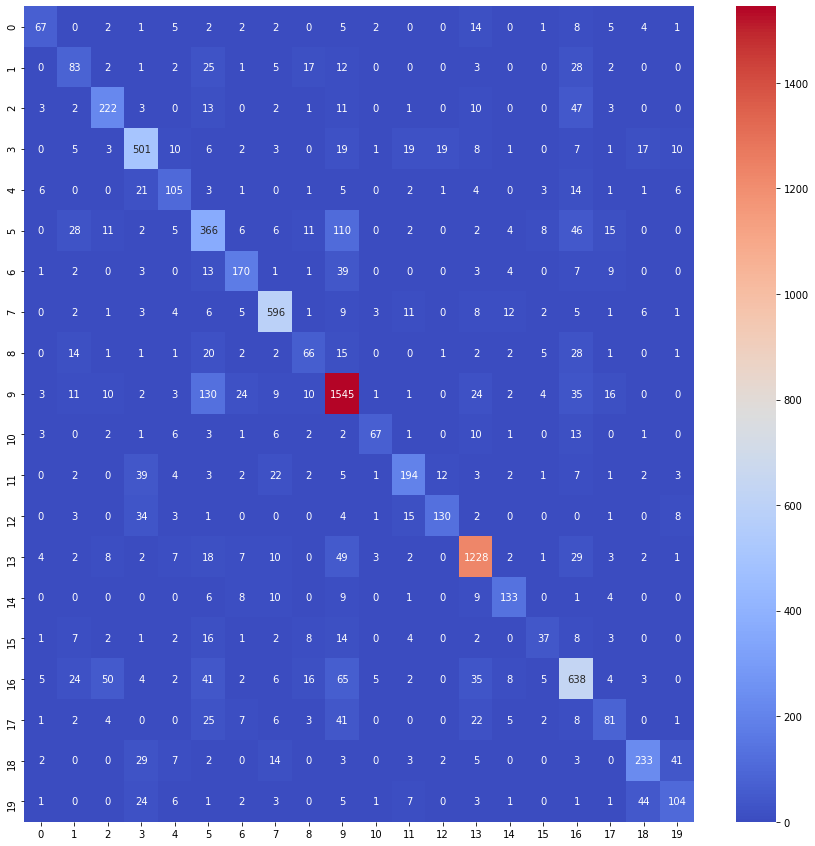

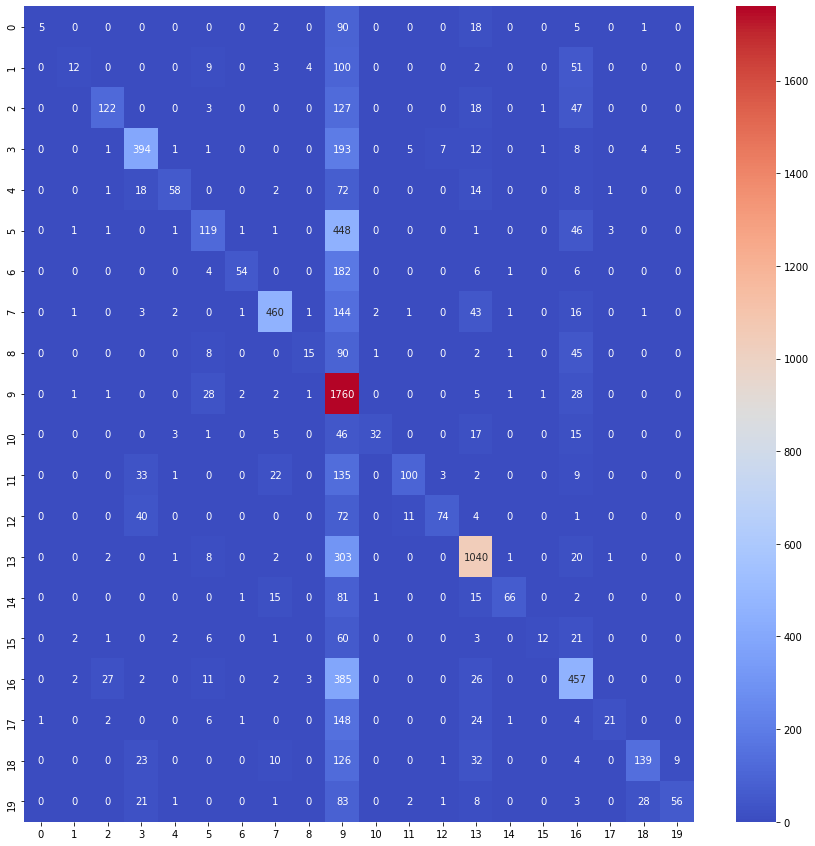

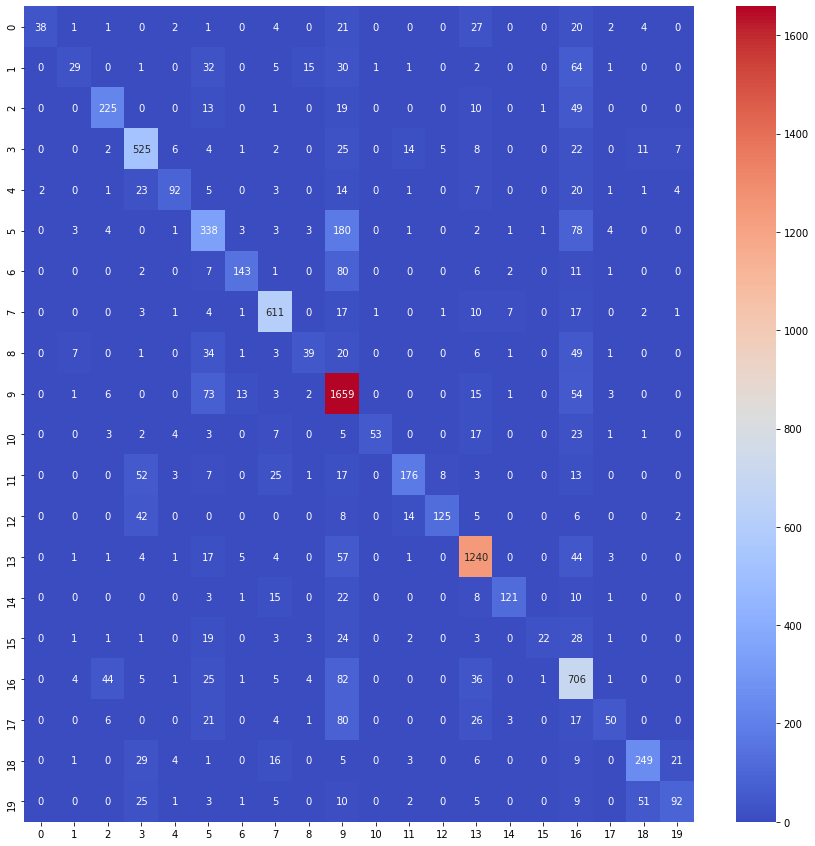

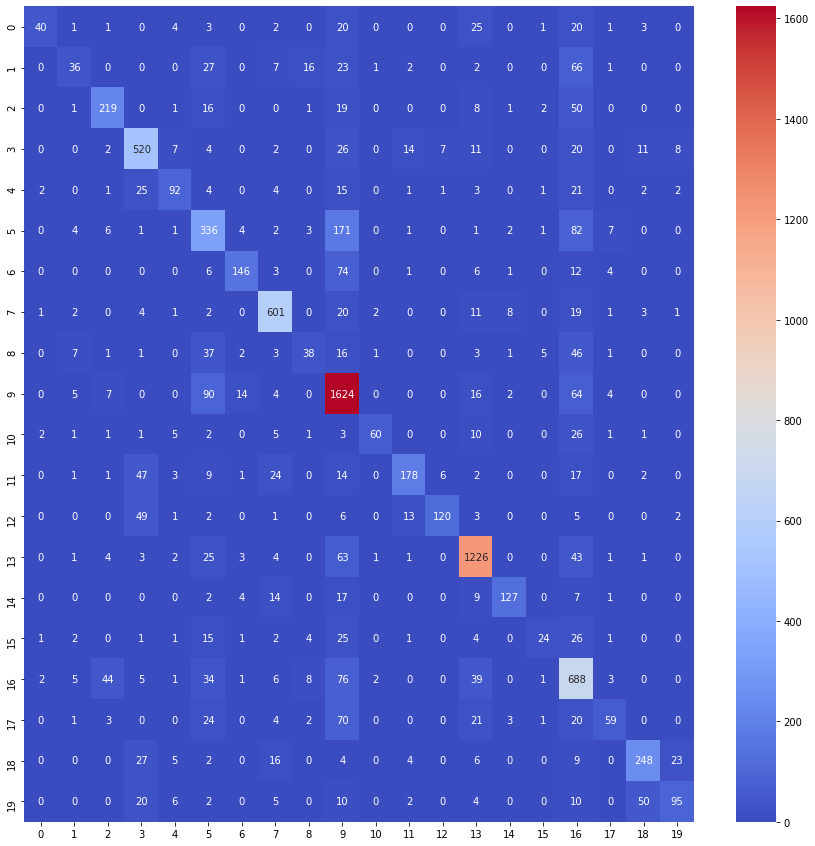

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

for i in range(len(pred)):
    print(i)
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(confusion_matrix(test_y, pred[i]),annot=True,cmap='coolwarm',fmt='d')
    print("recall: ", recall_score(test_y, pred[i], average='micro'))
    print("precision: ", precision_score(test_y, pred[i], average='macro'))
    print("accuracy: ", accuracy_score(test_y, pred[i]))
    print()
    plt.savefig(str(i))
    

In [18]:
sub = svm_clf_lin.predict(df_shuffle_test_pca)

In [19]:
submit = le.inverse_transform(pd.Series(sub))
submit = pd.concat([pd.Series(df_shuffle_test.id, name='Id'), pd.Series(submit, name='Category')], axis=1)
print(submit.to_csv(index=False))
submit.to_csv("submission.csv", index = False)


Id,Category
9356,italian
31575,southern_us
3603,southern_us
5099,brazilian
13393,mexican
33105,thai
18363,italian
10466,southern_us
25480,italian
4444,southern_us
11715,mexican
5766,moroccan
39856,filipino
6548,cajun_creole
23756,french
7334,southern_us
42644,chinese
47978,jamaican
10103,spanish
30801,mexican
6729,irish
42628,mexican
20048,cajun_creole
8633,italian
20666,mexican
30385,southern_us
27628,italian
24392,southern_us
37299,mexican
31384,japanese
35328,southern_us
40134,filipino
3808,mexican
10098,southern_us
31743,southern_us
30460,russian
13492,korean
10293,chinese
48993,mexican
26671,italian
13373,southern_us
18795,italian
17332,italian
42217,mexican
18034,southern_us
39009,chinese
44699,cajun_creole
11109,italian
614,mexican
2930,southern_us
35566,italian
13585,thai
1528,mexican
15593,thai
32751,mexican
40295,chinese
478,cajun_creole
23240,mexican
10355,french
31805,indian
5047,southern_us
27299,french
28988,mexican
48956,southern_us
15679,mexican
32291,southern_us
34061,

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_x = train_x.astype("float32")
train_y = train_y.astype("float32")
test_x = test_x.astype("float32")
test_y = test_y.astype("float32")
# Reserve 8933 samples for validation
val_x = train_x[-8933:]
val_y = train_y[-8933:]
train_x = train_x[:-8933]
train_y = train_y[:-8933]

Epoch 1/20
373/373 [==============================] - 9s 25ms/step - loss: 2.9412 - sparse_categorical_accuracy: 0.1993 - val_loss: 2.8925 - val_sparse_categorical_accuracy: 0.2942
Epoch 2/20
373/373 [==============================] - 7s 20ms/step - loss: 2.8186 - sparse_categorical_accuracy: 0.3201 - val_loss: 2.7481 - val_sparse_categorical_accuracy: 0.3205
Epoch 3/20
373/373 [==============================] - 8s 21ms/step - loss: 2.6471 - sparse_categorical_accuracy: 0.3338 - val_loss: 2.5731 - val_sparse_categorical_accuracy: 0.3338
Epoch 4/20
373/373 [==============================] - 8s 21ms/step - loss: 2.4730 - sparse_categorical_accuracy: 0.3557 - val_loss: 2.4235 - val_sparse_categorical_accuracy: 0.3582
Epoch 5/20
373/373 [==============================] - 8s 21ms/step - loss: 2.3339 - sparse_categorical_accuracy: 0.3847 - val_loss: 2.3049 - val_sparse_categorical_accuracy: 0.3924
Epoch 6/20
373/373 [==============================] - 8s 22ms/step - loss: 2.2176 - sparse_cate

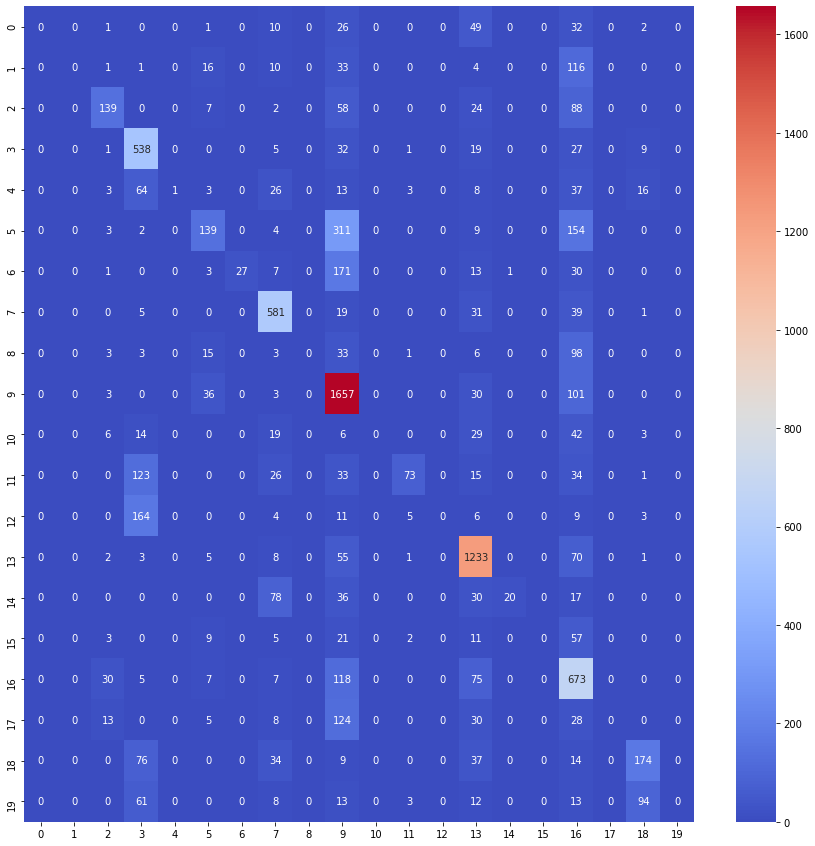

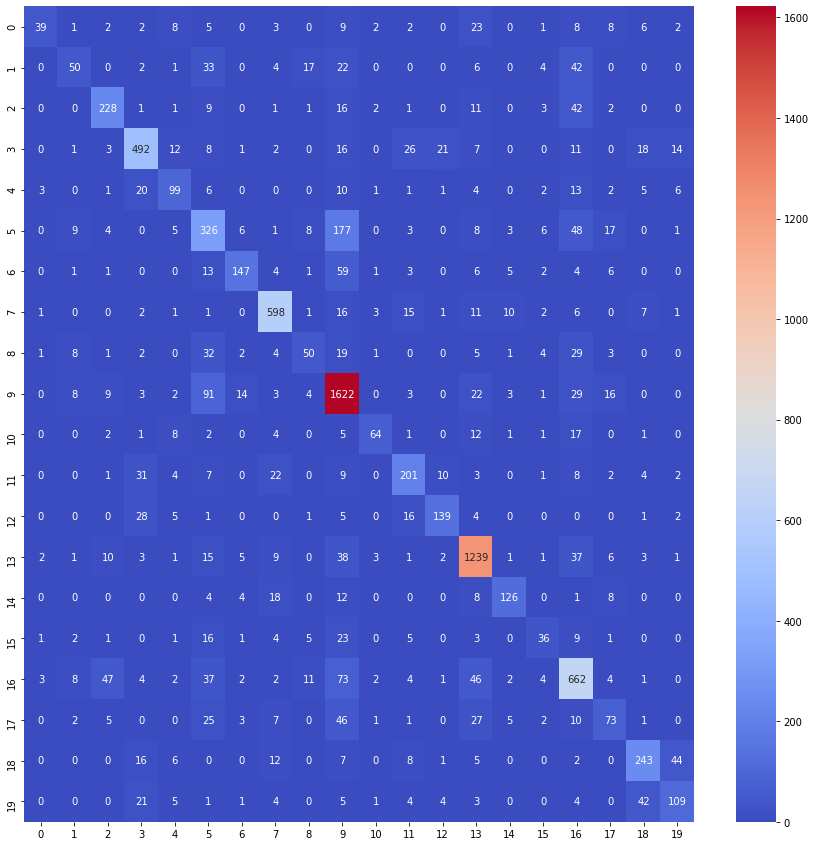

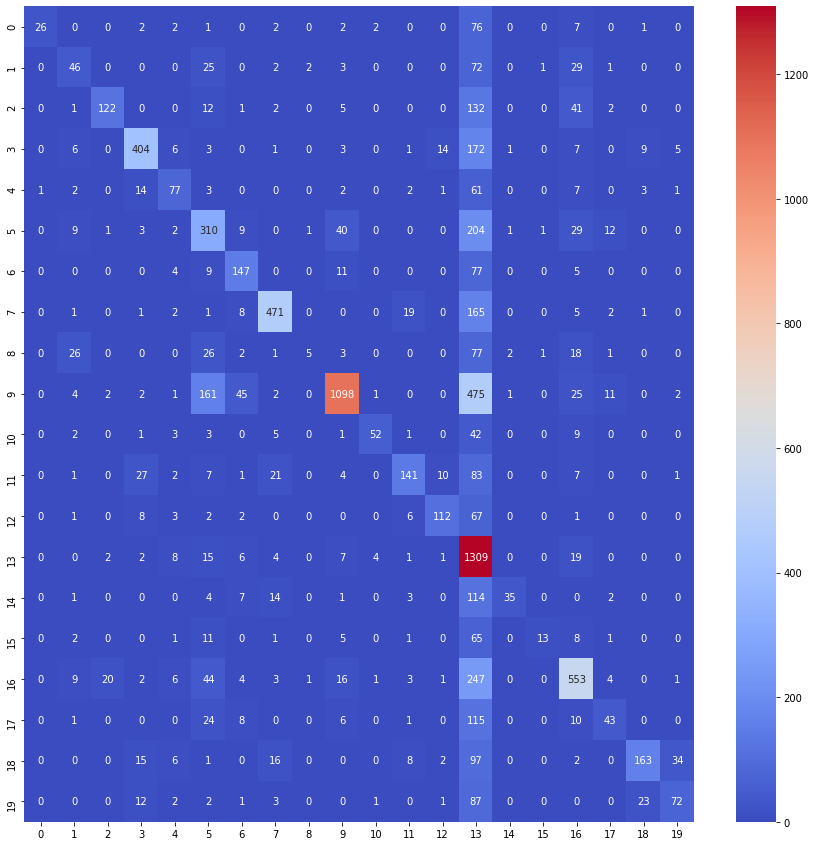

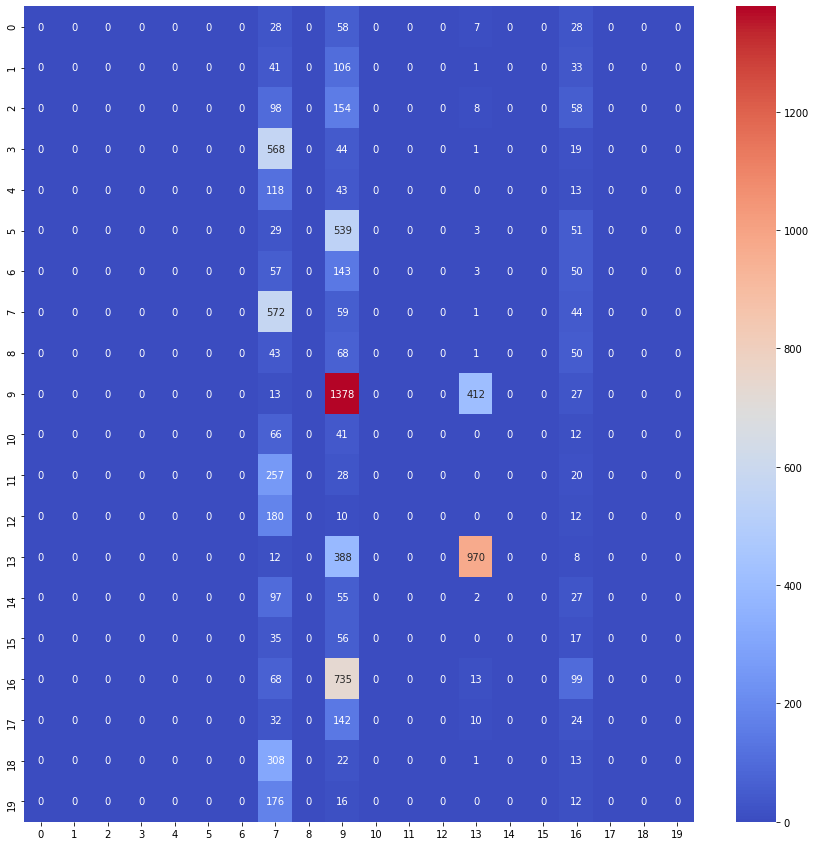

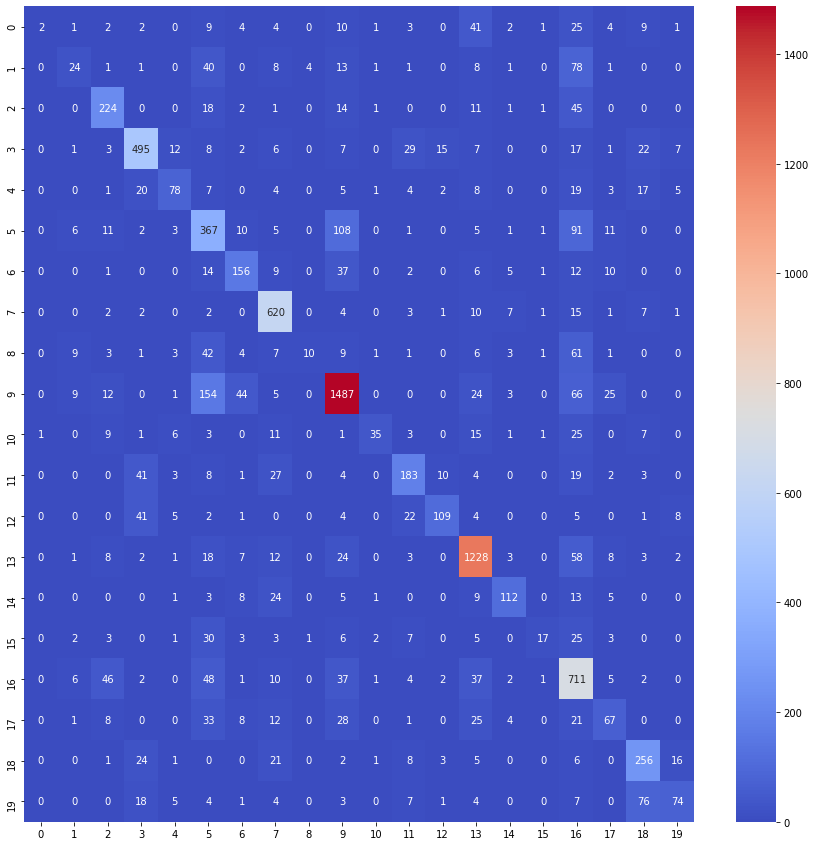

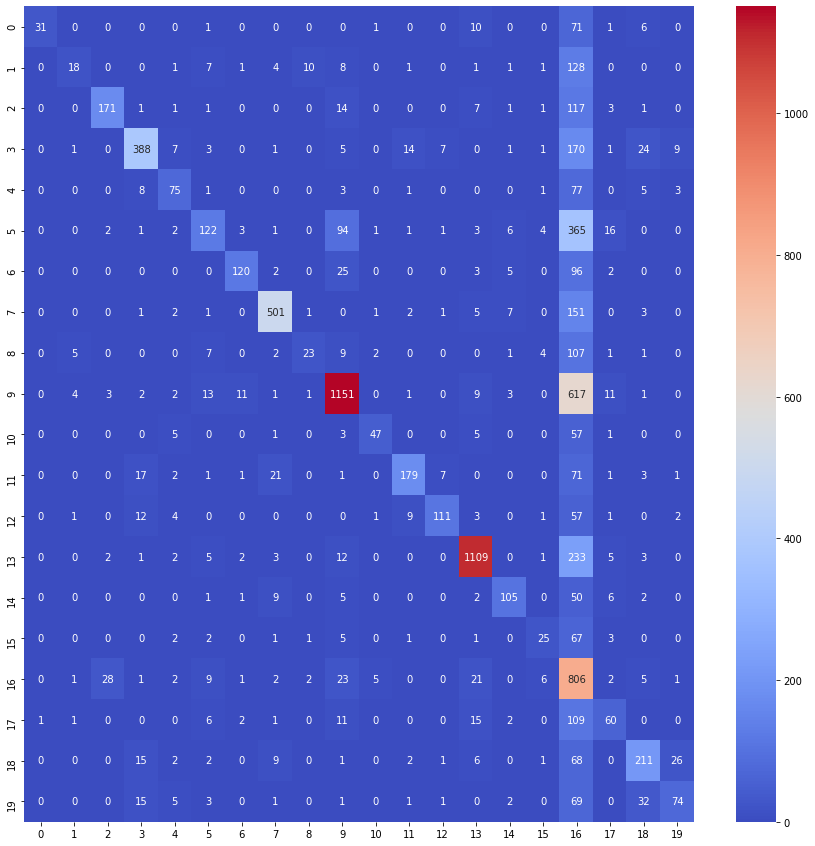

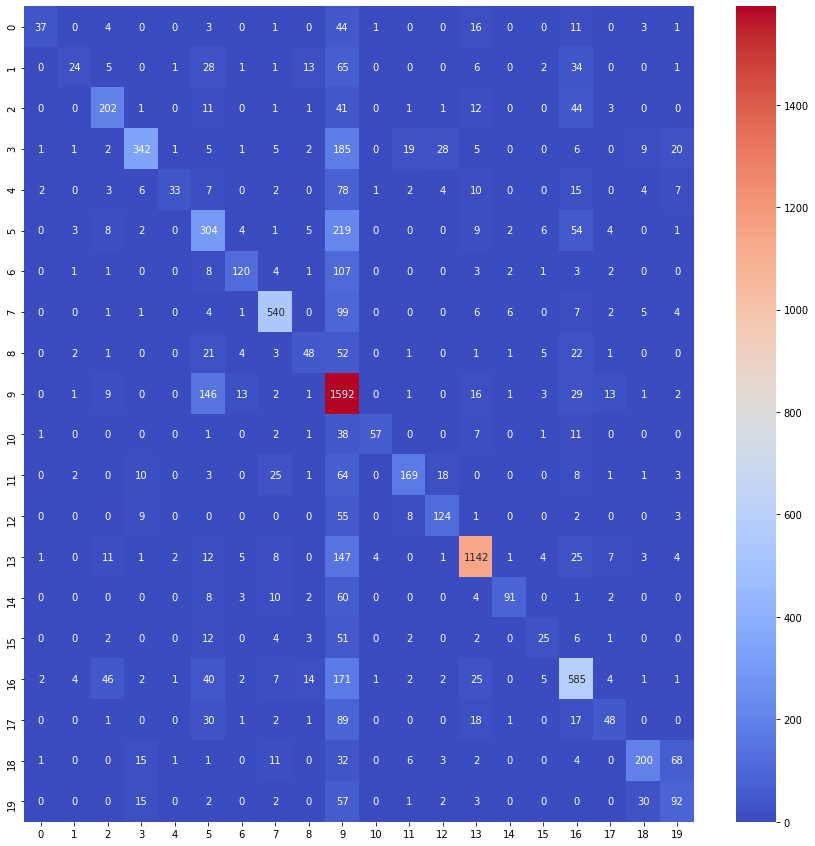

In [17]:
n = ["Adagrad", "Adam"]
m = [tf.keras.optimizers.Adadelta(0.01), tf.keras.optimizers.Adagrad(0.01), tf.keras.optimizers.Adam(0.01), tf.keras.optimizers.Ftrl(0.01), tf.keras.optimizers.SGD(0.01), tf.keras.optimizers.RMSprop(0.01), tf.keras.optimizers.Nadam(0.01)]
model_all = []

for i in range(len(m)):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(20)
    ])

    model.compile(
        optimizer=m[i],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    model.fit(
        train_x.values, train_y.values,
        epochs=60,
        validation_data=(val_x.values, val_y.values)
    )
    model_all.append(model)
    # model.summary()
    y = model.predict(test_x.values)
    pred = []
    for j in range(len(y)):
        pred.append(np.argmax(y[j]))
    # print(pred)

    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(confusion_matrix(test_y, pred),annot=True,cmap='coolwarm',fmt='d')
    print(n[i])
    print("recall: ", recall_score(test_y, pred, average='micro'))
    print("precision: ", precision_score(test_y, pred, average='macro'))
    print("accuracy: ", accuracy_score(test_y, pred))
    print()
    plt.savefig('EMG {0}.jpg'.format(i)) 


In [21]:
y = model_all[1].predict(df_shuffle_test_pca)
pred = []
for j in range(len(y)):
    pred.append(np.argmax(y[j]))

print(pred)


[9, 16, 16, 0, 13, 19, 9, 2, 9, 16, 13, 14, 4, 2, 5, 16, 3, 4, 17, 13, 8, 13, 2, 9, 13, 5, 9, 9, 4, 11, 16, 19, 13, 16, 16, 15, 19, 3, 13, 9, 16, 9, 9, 16, 16, 3, 15, 9, 13, 16, 9, 18, 13, 18, 13, 11, 2, 13, 5, 7, 8, 5, 13, 16, 13, 16, 2, 15, 3, 3, 16, 10, 16, 9, 18, 13, 9, 5, 6, 7, 16, 1, 16, 5, 9, 6, 10, 9, 13, 13, 19, 6, 13, 11, 13, 12, 7, 9, 2, 1, 13, 7, 9, 17, 13, 11, 16, 13, 0, 12, 13, 17, 15, 13, 9, 12, 13, 16, 16, 5, 3, 18, 16, 9, 16, 6, 9, 9, 7, 2, 11, 9, 13, 7, 13, 15, 13, 13, 9, 13, 13, 19, 14, 13, 8, 14, 9, 9, 9, 2, 5, 14, 5, 3, 3, 14, 11, 9, 9, 9, 12, 13, 16, 9, 9, 3, 2, 9, 18, 11, 8, 3, 7, 16, 3, 13, 6, 3, 1, 7, 0, 8, 6, 12, 16, 9, 9, 9, 12, 3, 9, 13, 2, 9, 13, 13, 18, 16, 2, 3, 5, 13, 13, 9, 7, 9, 15, 9, 13, 16, 9, 16, 9, 11, 16, 13, 3, 9, 8, 2, 13, 13, 9, 2, 3, 18, 3, 13, 18, 3, 16, 16, 9, 9, 15, 12, 18, 7, 9, 6, 9, 5, 13, 9, 9, 9, 9, 11, 9, 17, 9, 2, 16, 16, 9, 16, 9, 3, 17, 16, 9, 17, 18, 9, 6, 16, 16, 1, 9, 16, 7, 5, 2, 9, 17, 9, 9, 13, 7, 3, 13, 3, 6, 8, 3, 5, 9, 18

In [22]:
submit_nn = le.inverse_transform(pd.Series(pred))
submit_nn = pd.concat([pd.Series(df_shuffle_test.id, name='Id'), pd.Series(submit_nn, name='Category')], axis=1)
print(submit_nn)
submit_nn.to_csv("submission_nn.csv", index = False)

         Id     Category
0      9356      italian
1     31575  southern_us
2      3603  southern_us
3      5099    brazilian
4     13393      mexican
...     ...          ...
9995  24775      chinese
9996   7449      italian
9997  19211      mexican
9998   8966  southern_us
9999  29738      italian

[10000 rows x 2 columns]
